# Preparations

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 6]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize

import datetime
import yfinance as yf
import pandas_datareader.data as web

### Create time boundaries

In [5]:
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

In [7]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate

### Load the stock data

In [10]:
stock_data = yf.download(portfolio, start_date, end_date, interval='1d')
stock_data = stock_data['Close']
stock_data = stock_data.reset_index()

[*********************100%***********************]  13 of 13 completed


### Calculate metrics

In [12]:
# Find the quarterly return for each period
selected = list(stock_data.columns[1:])
returns = stock_data[selected].pct_change()
# Find the expected returns 
expected_returns = returns.mean()
# Find the covariance 
cov = returns.cov()

### Calculate target portfolio

In [14]:
gs10 = web.DataReader('GS10', 'fred', start_date, end_date)
riskfreerate = gs10.iloc[-1]['GS10']/100

In [15]:
def getNegativeSharpeRatio(weight, returns, cov, riskfreerate = 0):
    portfolioReturn = np.dot(weight , returns)*252
    portfolioStd = np.sqrt(np.dot(weight , np.dot(cov , weight.T)))*np.sqrt(252)
    return -(portfolioReturn - riskfreerate)/portfolioStd

In [16]:
min_stock_fraction = 1/(portfolio_len*2)
max_stock_fraction = 2/portfolio_len

bounds = tuple((min_stock_fraction, max_stock_fraction) for i in range(portfolio_len))

In [17]:
cons = (
    # Sum of weights must equate to 1
    {'type' : 'eq', 'fun' : lambda w : np.sum(w) - 1})

In [18]:
def maxSR(returns, cov, bounds, cons, riskfreerate = 0):
    args = (returns, cov, riskfreerate)
    result = minimize(fun=getNegativeSharpeRatio,
                      x0=current_weights,
                      args=args,
                      bounds=bounds, 
                      constraints=cons)
    return result

In [19]:
result = maxSR(expected_returns, cov, bounds, cons, riskfreerate=riskfreerate)
print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6091999377029577
       x: [ 1.538e-01  1.538e-01 ...  3.846e-02  5.127e-02]
     nit: 4
     jac: [-8.538e-01 -6.269e-01 ...  4.459e-01 -4.917e-02]
    nfev: 56
    njev: 4


# Results

In [21]:
current_return = np.dot(current_weights , expected_returns)*252
current_volatility = np.sqrt(np.dot(np.transpose(current_weights), np.dot(cov, current_weights)))
current_sharp_ratio = (current_return - riskfreerate)/current_volatility

In [22]:
optimized_weights = [float(round(x, 4)) for x in result['x']]

In [23]:
optimized_return = np.dot(optimized_weights , expected_returns)*252
optimized_volatility = np.sqrt(np.dot(np.transpose(optimized_weights), np.dot(cov, optimized_weights)))
optimized_sharp_ratio = (optimized_return - riskfreerate)/optimized_volatility

In [24]:
current_portfolio = pd.DataFrame(current_weights, index=portfolio, columns=['Current weights'])
optimized_portfolio = pd.DataFrame(optimized_weights, index=portfolio, columns=['Optimized weights'])

portfolios = pd.concat([current_portfolio, optimized_portfolio], axis=1)

portfolios

,Current weights,Optimized weights
AAPL,0.1269,0.1538
ABBV,0.1082,0.1538
BAC,0.0473,0.0385
BTI,0.0762,0.0385
C,0.0441,0.0385
CMCSA,0.0627,0.0385
FDX,0.1069,0.1538
GPS,0.1006,0.0641
HPQ,0.0716,0.1538
INTC,0.0401,0.0385


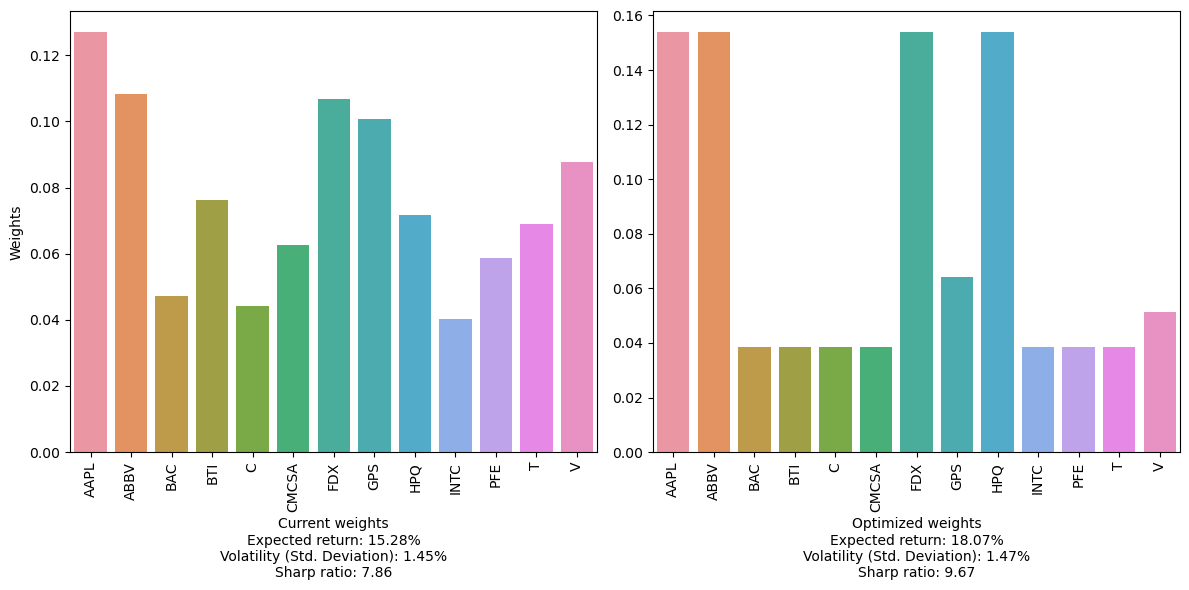

In [25]:
ax1 = plt.subplot(1,2,1)
sns.barplot(x=portfolios.index, y=portfolios['Current weights'])
plt.ylabel("Weights");
plt.xlabel(f"""Current weights
Expected return: {round(current_return*100,2)}%
Volatility (Std. Deviation): {round(current_volatility*100,2)}%
Sharp ratio: {round(current_sharp_ratio,2)}""");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(1,2,2)
sns.barplot(x=portfolios.index, y=portfolios['Optimized weights'])
plt.ylabel("");
plt.xlabel(f"""Optimized weights
Expected return: {round(optimized_return*100,2)}%
Volatility (Std. Deviation): {round(optimized_volatility*100,2)}%
Sharp ratio: {round(optimized_sharp_ratio,2)}""");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()